In [38]:
import numpy as np
import matplotlib.pyplot as plt
from preprocess_images import data_from_folder
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as T
from torchsummary import summary
import cv2 
import wandb
from config import LMDB_USE_COMPRESSION

import lmdb
import os
import msgpack
import lz4.frame

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [39]:
def imname_to_target(name:str) -> tuple[float, float]:
    """Parses image names of format x{x_value}_y{y_value}.jpg"""
    name = name.split('.jpg')[0]
    x, y = name.split("_")
    x = float(x[1:])
    if y[1] == '-':
        y = float(y[1:6])
    else:
        y = float(y[1:5])
    return x, y

In [40]:
class LMDBImageDataset(Dataset):
    def __init__(self, lmdb_path, transforms=None, keys_fname="keys.txt", flatten_data=True):
        self.keys = None

        # Data augmentation
        self.transforms = transforms

        # Read text keys from file
        with open(os.path.join(lmdb_path, keys_fname)) as f:
            self.keys = f.readlines()
            if self.keys[-1] == '':
                self.keys = self.keys[:-1]
        for i in range(len(self.keys)):
            self.keys[i] = self.keys[i].replace("\n", "")

        # Get labels from text keys
        self.labels = []
        # self.labels = [imname_to_target(key) for key in self.keys]
        for i, key in enumerate(self.keys):
            try:
                self.labels.append(imname_to_target(key))
            except Exception as e:
                print("i:", i)
                print("name:", key)
                raise e

        # Encode keys
        for i in range(len(self.keys)):
            self.keys[i] = self.keys[i].encode()

        self.lmdb_path = lmdb_path
        self.flatten_data = flatten_data

    def open_lmdb(self):
        self.env = lmdb.open(self.lmdb_path, readonly=True, create=False, lock=False, readahead=False, meminit=False)
        self.txn = self.env.begin()

    def close(self):
        self.env.close()

    def __len__(self):
        return len(self.keys)
    
    def add_coord_channels(self, image_tensor):
        _, H, W = image_tensor.shape

        x_coords = torch.linspace(-1, 1, W, device=image_tensor.device)
        y_coords = torch.linspace(-1, 1, H, device=image_tensor.device)

        x_coords = x_coords.view(1, 1, W).expand(1, H, W)
        y_coords = y_coords.view(1, H, 1).expand(1, H, W)

        return torch.cat([image_tensor, x_coords, y_coords], dim=0)
    
    def __getitem__(self, index):
        if not hasattr(self, 'txn'):
            print("Opening lmdb txn")
            self.open_lmdb()
        key = self.keys[index]  # Get corresponding tuple
        label = self.labels[index]
        
        img_bytes = self.txn.get(key)
        
        if img_bytes is None:
            raise KeyError(f"Image {key} not found in LMDB!")

        if LMDB_USE_COMPRESSION:
            img_bytes = lz4.frame.decompress(img_bytes)

        image = np.array(msgpack.unpackb(img_bytes, raw=False), dtype=np.uint8)
        

        # Convert image to Tensor, and normalize [0,1]
        
        if not self.flatten_data:
            if len(image.shape)==2:
                image = torch.from_numpy(np.array([image])).float()
            if len(image.shape)==3:
                image = torch.from_numpy(np.array(image)).float()
                image = image.permute(2, 0, 1)
        image = image / 255.0

        # Augmenation
        if self.transforms is not None:
            image = self.transforms(image)

        if self.flatten_data:
            image = torch.from_numpy(image).flatten().float()
            self.debug_msg = f"image shape {image.shape}"
        elif isinstance(image, np.ndarray):
            image = torch.unsqueeze(torch.from_numpy(image), 0)
            # print(image.shape)
        # image = self.add_coord_channels(image)

        # Convert label tuple to Tensor
        x, y = label
        x = (x + 2) / 5.7
        y = (y + 2) / 4
        label = (x, y)
        label = torch.tensor(label, dtype=torch.float32)

        return image, label

In [41]:
class LMDBDoGTripletDataset(LMDBImageDataset):
    def __getitem__(self, index):
        if not hasattr(self, 'txn'):
            self.open_lmdb()

        base_key_bytes = self.keys[index]
        base_key_str = base_key_bytes.decode()
        dark_key = base_key_str.replace('-light.jpg', '.jpg').replace('-mainlight.jpg', '.jpg')
        light_key = dark_key.replace('.jpg', '-light.jpg')
        mainlight_key = dark_key.replace('.jpg', '-mainlight.jpg')

        keys = [dark_key.encode(), light_key.encode(), mainlight_key.encode()]

        def load_image(key):
            try:
                img_bytes = self.txn.get(key)
                if img_bytes is None:
                    return None
                if LMDB_USE_COMPRESSION:
                    img_bytes = lz4.frame.decompress(img_bytes)
                img_np = np.array(msgpack.unpackb(img_bytes, raw=False), dtype=np.uint8)
                img_tensor = torch.from_numpy(img_np).float()
                if img_tensor.ndim == 3:
                    img_tensor = img_tensor.permute(2, 0, 1)
                img_tensor = img_tensor / 255.0
                if self.transforms:
                    img_tensor = self.transforms(img_tensor)
                return img_tensor
            except Exception as e:
                return None

        dark = load_image(keys[0])
        light = load_image(keys[1])
        mainlight = load_image(keys[2])

        if dark is None or light is None or mainlight is None:
            return None

        return {'dark': dark, 'light': light, 'mainlight': mainlight, 'name': base_key_str}


In [42]:
import torch.nn.functional as F

def make_gaussian_kernel_fixed(sigma, max_kernel_size=61):
    """Return a 2D Gaussian kernel embedded in a fixed-size canvas."""
    device = sigma.device

    # Ensure kernel size is odd and not larger than max_kernel_size
    kernel_size = int(torch.minimum(torch.ceil(6 * sigma + 1), torch.tensor(max_kernel_size, device=device)).item())
    if kernel_size % 2 == 0:
        kernel_size -= 1  # Make it odd for symmetry

    half = kernel_size // 2
    ax = torch.arange(-half, half + 1, device=device).float()
    xx, yy = torch.meshgrid(ax, ax, indexing='ij')
    kernel = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel = kernel / kernel.sum()

    # Embed in fixed-size canvas
    full_kernel = torch.zeros((max_kernel_size, max_kernel_size), device=device)
    start = (max_kernel_size - kernel_size) // 2
    full_kernel[start:start+kernel_size, start:start+kernel_size] = kernel

    return full_kernel

def apply_gaussian_blur_fixed(img, kernel):
    # img: (B, 3, H, W), kernel: (kH, kW)
    B, C, H, W = img.shape
    kernel = kernel.unsqueeze(0).unsqueeze(0)  # [1, 1, kH, kW]
    kernel = kernel.to(img.device)
    padding = kernel.shape[-1] // 2

    blurred = F.conv2d(img.view(B*C, 1, H, W), kernel, padding=padding)
    return blurred.view(B, C, H, W)

class DifferentiableDoG(torch.nn.Module):
    def __init__(self, init_sigma1=1.0, init_sigma2=2.0, max_kernel_size=61):
        super().__init__()
        self.log_sigma1 = torch.nn.Parameter(torch.log(torch.tensor(init_sigma1)))
        self.log_sigma2 = torch.nn.Parameter(torch.log(torch.tensor(init_sigma2)))
        self.max_kernel_size = max_kernel_size

    def forward(self, x):
        sigma1 = torch.exp(self.log_sigma1)#.clamp(min=0.5, max=4.0)
        sigma2 = torch.exp(self.log_sigma2)#.clamp(min=1.5, max=8.0)

        kernel1 = make_gaussian_kernel_fixed(sigma1, self.max_kernel_size)
        kernel2 = make_gaussian_kernel_fixed(sigma2, self.max_kernel_size)

        blur1 = apply_gaussian_blur_fixed(x, kernel1)
        blur2 = apply_gaussian_blur_fixed(x, kernel2)

        return blur1 - blur2



In [43]:
config = {
    "data_folder": "/mnt/e/color.lmdb",
    "dataset_train_keys_fname": "016_color_train.txt"    
}

In [44]:
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None
    darks = torch.stack([b['dark'] for b in batch])
    lights = torch.stack([b['light'] for b in batch])
    mainlights = torch.stack([b['mainlight'] for b in batch])
    names = [b['name'] for b in batch]
    return {'dark': darks, 'light': lights, 'mainlight': mainlights, 'name': names}


In [45]:
dataset = LMDBDoGTripletDataset(config["data_folder"], flatten_data=False, keys_fname=config["dataset_train_keys_fname"])
model = DifferentiableDoG().cuda(0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
from torch.utils.data import DataLoader

dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn,
    drop_last=True,  # to ensure all batches are full
    # pin_memory=True,
    prefetch_factor=2,
)

In [46]:
model.train()
num_epochs = 30
for epoch in range(num_epochs):
    total_loss = 0.0
    progress = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch in progress:
        if batch is None:
            continue

        dark = batch['dark'].cuda()
        light = batch['light'].cuda()
        mainlight = batch['mainlight'].cuda()

        # out_light = model(light)
        out_dark = model(dark)
        out_mainlight = model(mainlight)
        # target = dark
        target = light

        # loss = F.l1_loss(out_light, target) + F.l1_loss(out_mainlight, target)
        loss = F.l1_loss(out_dark, target) + F.l1_loss(out_mainlight, target)
        sigma1 = torch.exp(model.log_sigma1)
        sigma2 = torch.exp(model.log_sigma2)

        loss += 0.01 * (sigma1 + sigma2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        avg_loss = total_loss / (progress.n + 1)
        progress.set_postfix(loss=avg_loss)

    print(f"Epoch {epoch+1} complete - Average Loss: {avg_loss:.4f}")
    print(f"Sigma1: {sigma1.item():.2f}, Sigma2: {sigma2.item():.2f}, Ratio: {sigma2.item()/sigma1.item():.2f}")


Epoch 1/30: 100%|██████████| 135/135 [02:28<00:00,  1.10s/it, loss=0.717]


Epoch 1 complete - Average Loss: 0.7168
Sigma1: 0.34, Sigma2: 0.68, Ratio: 1.99


Epoch 2/30: 100%|██████████| 135/135 [02:33<00:00,  1.14s/it, loss=0.707]


Epoch 2 complete - Average Loss: 0.7067
Sigma1: 0.18, Sigma2: 0.35, Ratio: 1.97


Epoch 3/30: 100%|██████████| 135/135 [02:35<00:00,  1.15s/it, loss=0.704]


Epoch 3 complete - Average Loss: 0.7035
Sigma1: 0.11, Sigma2: 0.22, Ratio: 1.95


Epoch 4/30: 100%|██████████| 135/135 [02:34<00:00,  1.15s/it, loss=0.702]


Epoch 4 complete - Average Loss: 0.7021
Sigma1: 0.08, Sigma2: 0.15, Ratio: 1.93


Epoch 5/30: 100%|██████████| 135/135 [02:35<00:00,  1.15s/it, loss=0.701]


Epoch 5 complete - Average Loss: 0.7013
Sigma1: 0.06, Sigma2: 0.11, Ratio: 1.92


Epoch 6/30: 100%|██████████| 135/135 [02:34<00:00,  1.14s/it, loss=0.701]


Epoch 6 complete - Average Loss: 0.7008
Sigma1: 0.04, Sigma2: 0.08, Ratio: 1.92


Epoch 7/30: 100%|██████████| 135/135 [02:33<00:00,  1.14s/it, loss=0.7]  


Epoch 7 complete - Average Loss: 0.7005
Sigma1: 0.03, Sigma2: 0.07, Ratio: 1.92


Epoch 8/30: 100%|██████████| 135/135 [02:34<00:00,  1.15s/it, loss=0.7]  


Epoch 8 complete - Average Loss: 0.7003
Sigma1: 0.03, Sigma2: 0.05, Ratio: 1.91


Epoch 9/30: 100%|██████████| 135/135 [02:32<00:00,  1.13s/it, loss=0.7] 


Epoch 9 complete - Average Loss: 0.7001
Sigma1: 0.02, Sigma2: 0.04, Ratio: 1.91


Epoch 10/30: 100%|██████████| 135/135 [02:31<00:00,  1.12s/it, loss=0.7] 


Epoch 10 complete - Average Loss: 0.7000
Sigma1: 0.02, Sigma2: 0.04, Ratio: 1.91


Epoch 11/30: 100%|██████████| 135/135 [02:32<00:00,  1.13s/it, loss=0.7] 


Epoch 11 complete - Average Loss: 0.6999
Sigma1: 0.02, Sigma2: 0.03, Ratio: 1.91


Epoch 12/30: 100%|██████████| 135/135 [02:32<00:00,  1.13s/it, loss=0.7] 


Epoch 12 complete - Average Loss: 0.6998
Sigma1: 0.01, Sigma2: 0.03, Ratio: 1.91


Epoch 13/30: 100%|██████████| 135/135 [02:31<00:00,  1.12s/it, loss=0.7]  


Epoch 13 complete - Average Loss: 0.6997
Sigma1: 0.01, Sigma2: 0.02, Ratio: 1.91


Epoch 14/30: 100%|██████████| 135/135 [02:32<00:00,  1.13s/it, loss=0.7]  


Epoch 14 complete - Average Loss: 0.6997
Sigma1: 0.01, Sigma2: 0.02, Ratio: 1.91


Epoch 15/30: 100%|██████████| 135/135 [02:31<00:00,  1.12s/it, loss=0.7]  


Epoch 15 complete - Average Loss: 0.6997
Sigma1: 0.01, Sigma2: 0.02, Ratio: 1.91


Epoch 16/30: 100%|██████████| 135/135 [02:34<00:00,  1.14s/it, loss=0.7]  


Epoch 16 complete - Average Loss: 0.6996
Sigma1: 0.01, Sigma2: 0.02, Ratio: 1.91


Epoch 17/30: 100%|██████████| 135/135 [02:32<00:00,  1.13s/it, loss=0.7] 


Epoch 17 complete - Average Loss: 0.6996
Sigma1: 0.01, Sigma2: 0.01, Ratio: 1.91


Epoch 18/30: 100%|██████████| 135/135 [02:32<00:00,  1.13s/it, loss=0.7]  


Epoch 18 complete - Average Loss: 0.6996
Sigma1: 0.01, Sigma2: 0.01, Ratio: 1.91


Epoch 19/30: 100%|██████████| 135/135 [02:33<00:00,  1.14s/it, loss=0.7]  


Epoch 19 complete - Average Loss: 0.6995
Sigma1: 0.01, Sigma2: 0.01, Ratio: 1.91


Epoch 20/30: 100%|██████████| 135/135 [02:32<00:00,  1.13s/it, loss=0.7] 


Epoch 20 complete - Average Loss: 0.6995
Sigma1: 0.01, Sigma2: 0.01, Ratio: 1.91


Epoch 21/30: 100%|██████████| 135/135 [02:32<00:00,  1.13s/it, loss=0.7]  


Epoch 21 complete - Average Loss: 0.6995
Sigma1: 0.01, Sigma2: 0.01, Ratio: 1.91


Epoch 22/30: 100%|██████████| 135/135 [02:32<00:00,  1.13s/it, loss=0.699]


Epoch 22 complete - Average Loss: 0.6995
Sigma1: 0.00, Sigma2: 0.01, Ratio: 1.90


Epoch 23/30: 100%|██████████| 135/135 [02:32<00:00,  1.13s/it, loss=0.699]


Epoch 23 complete - Average Loss: 0.6995
Sigma1: 0.00, Sigma2: 0.01, Ratio: 1.90


Epoch 24/30: 100%|██████████| 135/135 [02:32<00:00,  1.13s/it, loss=0.699]


Epoch 24 complete - Average Loss: 0.6995
Sigma1: 0.00, Sigma2: 0.01, Ratio: 1.90


Epoch 25/30: 100%|██████████| 135/135 [02:32<00:00,  1.13s/it, loss=0.699]


Epoch 25 complete - Average Loss: 0.6995
Sigma1: 0.00, Sigma2: 0.01, Ratio: 1.90


Epoch 26/30: 100%|██████████| 135/135 [02:35<00:00,  1.16s/it, loss=0.699]


Epoch 26 complete - Average Loss: 0.6994
Sigma1: 0.00, Sigma2: 0.01, Ratio: 1.90


Epoch 27/30: 100%|██████████| 135/135 [02:33<00:00,  1.14s/it, loss=0.699]


Epoch 27 complete - Average Loss: 0.6994
Sigma1: 0.00, Sigma2: 0.01, Ratio: 1.90


Epoch 28/30: 100%|██████████| 135/135 [02:32<00:00,  1.13s/it, loss=0.699]


Epoch 28 complete - Average Loss: 0.6994
Sigma1: 0.00, Sigma2: 0.01, Ratio: 1.90


Epoch 29/30: 100%|██████████| 135/135 [02:32<00:00,  1.13s/it, loss=0.699]


Epoch 29 complete - Average Loss: 0.6994
Sigma1: 0.00, Sigma2: 0.00, Ratio: 1.90


Epoch 30/30: 100%|██████████| 135/135 [02:35<00:00,  1.15s/it, loss=0.699]

Epoch 30 complete - Average Loss: 0.6994
Sigma1: 0.00, Sigma2: 0.00, Ratio: 1.90


In [47]:
print(torch.exp(model.log_sigma1))
print(torch.exp(model.log_sigma2))

tensor(0.0022, device='cuda:0', grad_fn=<ExpBackward0>)
tensor(0.0043, device='cuda:0', grad_fn=<ExpBackward0>)


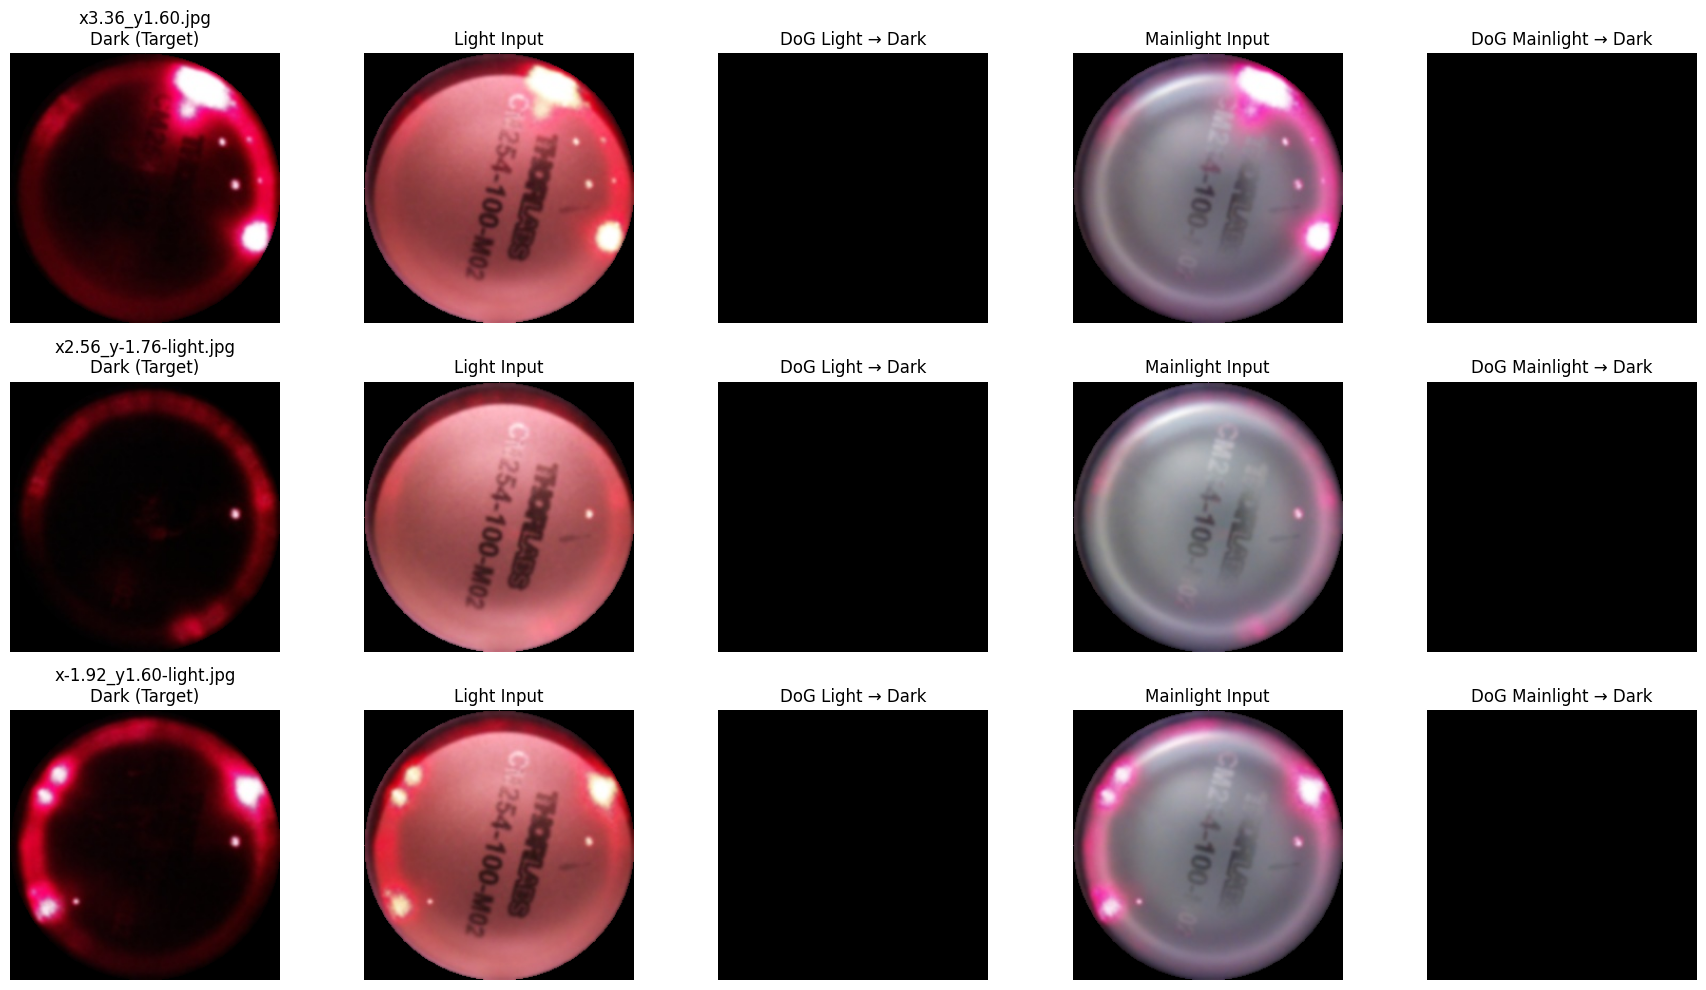

In [48]:

# --- Visualize 3 Examples ---
model.eval()
samples = [dataset[i] for i in range(3)]  # assuming 'train_dataset' is your current dataset

fig, axes = plt.subplots(3, 5, figsize=(18, 10))
for i, sample in enumerate(samples):
    dark = sample['dark'].unsqueeze(0).cuda(0)       # [ 3, H, W]
    light = sample['light'].unsqueeze(0).cuda(0)
    mainlight = sample['mainlight'].unsqueeze(0).cuda(0)
    name = sample['name']

    with torch.no_grad():
        norm_light = model(light).squeeze(0).cpu()       # [3, H, W]
        norm_mainlight = model(mainlight).squeeze(0).cpu()

    # Show target dark image (reference)
    axes[i, 0].imshow(sample['dark'].permute(1, 2, 0).cpu())
    axes[i, 0].set_title(f"{name}\nDark (Target)")

    # Original light
    axes[i, 1].imshow(sample['light'].permute(1, 2, 0).cpu())
    axes[i, 1].set_title("Light Input")

    # Normalized light → dark
    axes[i, 2].imshow(norm_light.permute(1, 2, 0).clamp(0, 1))
    axes[i, 2].set_title("DoG Light → Dark")

    # Original mainlight
    axes[i, 3].imshow(sample['mainlight'].permute(1, 2, 0).cpu())
    axes[i, 3].set_title("Mainlight Input")

    # Normalized mainlight → dark
    axes[i, 4].imshow(norm_mainlight.permute(1, 2, 0).clamp(0, 1))
    axes[i, 4].set_title("DoG Mainlight → Dark")

for ax_row in axes:
    for ax in ax_row:
        ax.axis('off')

plt.tight_layout()
plt.show()
